In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
# import glob2 as glob
import matplotlib as mpl

import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress
from aux_funcs import compressed_read
from copy import deepcopy as copy

In [23]:
def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

def load_compressed_data(data_path, indices=[]):
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = compressed_read(os.path.join(data_path, file_name))
            yield data_for_file

def load_behavioral_data(data_path, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_compressed_data(
        data_path,
        indices=indices,
    )

    return state_data.__next__()

def parse_behavioral_data(d, env_idx):
    features = [
        'agent_in_patch',
        'current_patch_start',
        'reward_bounds',
        'current_patch_num',
        'action',
        'current_position',
        'reward',
        'patch_reward_param',
        'current_reward_site_attempted',
    ]

    features_to_time_series_dict = {}
    for f in features:
        features_to_time_series_dict[f] = []
        
    for k in np.arange(len(d)):
        for f in features:
            features_to_time_series_dict[f].append(d[k][f][env_idx])
            
    for f in features:
        try:
            features_to_time_series_dict[f] = np.array(features_to_time_series_dict[f])
        except e:
            print(e)

    all_dwell_times = []
    rewards_at_positions = [0]
    reward_attempted_at_positions = [False]
    dwell_time = 0
    last_p = None
    rewards_seen_in_patch = np.zeros((len(d)))
    
    for i, p in enumerate(features_to_time_series_dict['current_position']):
        if last_p is not None and (p != last_p):
            all_dwell_times.append(dwell_time)
            rewards_at_positions.append(0)
            reward_attempted_at_positions.append(False)
            dwell_time = 0
        if last_p is not None:
            dwell_time += 1
        rewards_at_positions[-1] += features_to_time_series_dict['reward'][i]
        reward_attempted_at_positions[-1] = True if features_to_time_series_dict['current_reward_site_attempted'][i] else reward_attempted_at_positions[-1]
        last_p = p

        if features_to_time_series_dict['agent_in_patch'][i]:
            if i > 0:
                rewards_seen_in_patch[i] = rewards_seen_in_patch[i-1] + features_to_time_series_dict['reward'][i]
            else:
                rewards_seen_in_patch[i] = features_to_time_series_dict['reward'][i]
    
    features_to_time_series_dict['rewards_at_positions'] = np.array(rewards_at_positions)
    features_to_time_series_dict['reward_attempted_at_positions'] = np.array(reward_attempted_at_positions)
    features_to_time_series_dict['all_dwell_times'] = np.array(all_dwell_times)
    features_to_time_series_dict['rewards_seen_in_patch'] = rewards_seen_in_patch

    return features_to_time_series_dict

In [39]:
def plot_sesson(data_path, env_idx, update_num=None, xlim=None, max_reward_param=30, max_reward_sites=8):

    b_data_raw = load_behavioral_data(data_path, update_num)
    b_data = parse_behavioral_data(b_data_raw, env_idx)

    rewards_at_positions = b_data['rewards_at_positions']
    reward_attempted_at_positions = b_data['reward_attempted_at_positions']
    all_patch_nums = b_data['current_patch_num']
    all_patch_reward_params = b_data['patch_reward_param']
    rewards_seen_in_patch = b_data['rewards_seen_in_patch']
              
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))
    
    axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='purple', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='purple', marker='s')
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, max_reward_sites))
    acc_reward_stops_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    acc_reward_stop_opportunities_for_patch_type = np.zeros((all_patch_nums.max() + 1, 40))
    patches_entered_for_patch_type = np.zeros((all_patch_nums.max() + 1,))
    reward_param_for_patch_type = np.zeros((all_patch_nums.max() + 1,))

    cmap = mpl.colormaps['winter']
    
    s_0 = 1.1
    s_1 = 1.75
    last_pstart = None
    pb = None
    last_reward_site_start = None
    reward_site_start = None
    patch_count = 0
    rw_site_counter = 0
    plotted_cnt = 0

    for i, pstart in enumerate(b_data['current_patch_start']):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb = [pstart, pstart]
            c = cmap(all_patch_reward_params[i] / max_reward_param) if all_patch_reward_params[i] > 0 else 'black'
            rw_site_counter = 0
        
        rwsb = copy(b_data['reward_bounds'][i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or last_reward_site_start != reward_site_start:
            axs.fill_between(list(rwsb), s_0 * np.ones(2), y2=s_1 * np.ones(2), alpha=0.5, color=c, zorder=-1)
            axs.fill_between(list(rwsb), np.zeros(2), y2=s_0 * np.ones(2), alpha=0.2, color=c, zorder=-1)

            if rewards_seen_in_patch[i] < 40:
                acc_reward_stop_opportunities_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
            
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                pb[1] = rwsb[1]
                axs.fill_between(pb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=c, zorder=-2)
                axs.fill_between(pb, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=c, zorder=-2)
            else:
                reward_param_of_stop.append(b_data['patch_reward_param'][i])
                site_idx_of_stop.append(rw_site_counter)
                if rw_site_counter < max_reward_sites:
                    # print('cnt', rw_site_counter)
                    site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                if rewards_seen_in_patch[i] < 40:
                    acc_reward_stops_for_patch_type[all_patch_nums[i], int(rewards_seen_in_patch[i])] += 1
                rw_site_counter += 1
        
        last_pstart = pstart
        last_reward_site_start = reward_site_start

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    print('Patch count:', patch_count)
    
    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(site_stops_for_patch_type.shape[1])
    for k in range(site_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Odor site number in patch')

    scale = 1
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(acc_reward_stops_for_patch_type.shape[1])
    for k in range(acc_reward_stops_for_patch_type.shape[0]):
        c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
        axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)
        # axs[k].set_ylim(0, 1.1)
    axs[0].set_xlim(-3, 43)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Total reward in patch')
    
    print(reward_param_for_patch_type)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\1140789502.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 350
[ 0. 10. 30.]


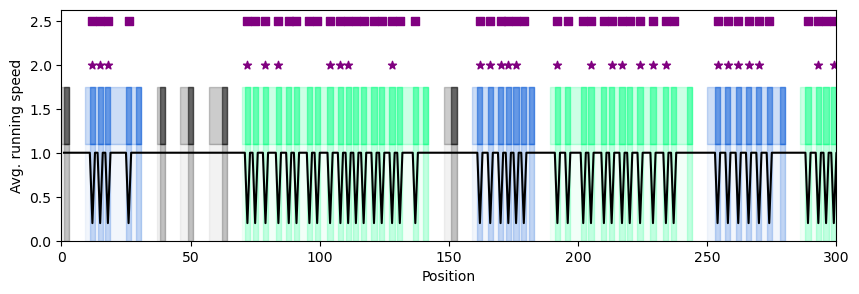

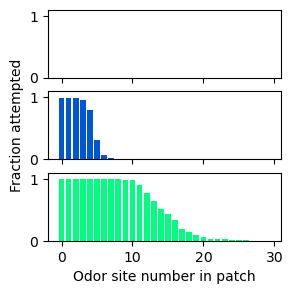

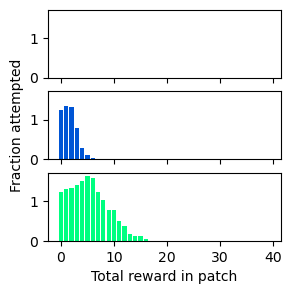

In [29]:
plot_sesson(
    '../../results/rl_agent_outputs/structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_27916\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 322
[ 0. 10. 30.]


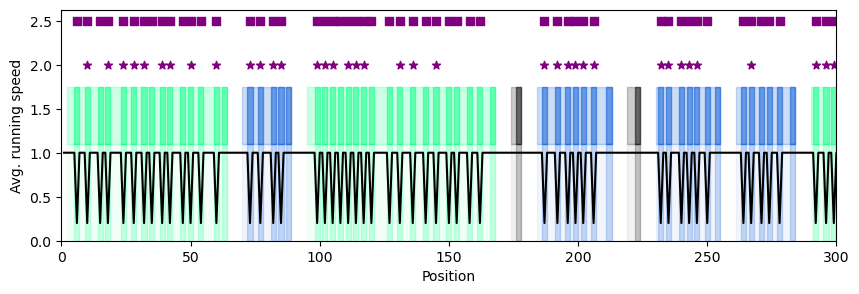

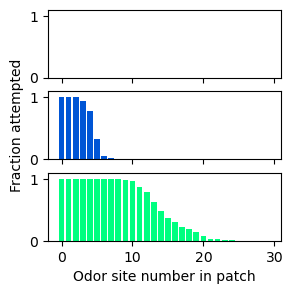

In [6]:
plot_sesson(
    '../../results/rl_agent_outputs/structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 323
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:101: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


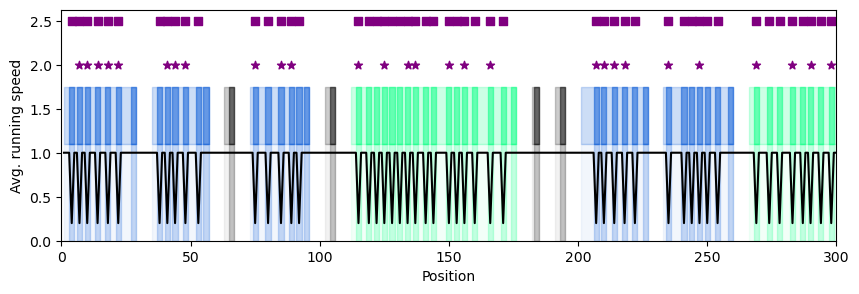

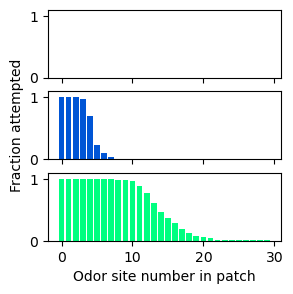

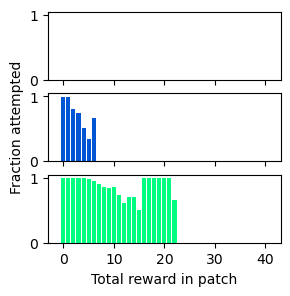

In [47]:
plot_sesson(
    '../../results/rl_agent_outputs/structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/state',
    env_idx=2,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 308
[ 0. 10. 30.]


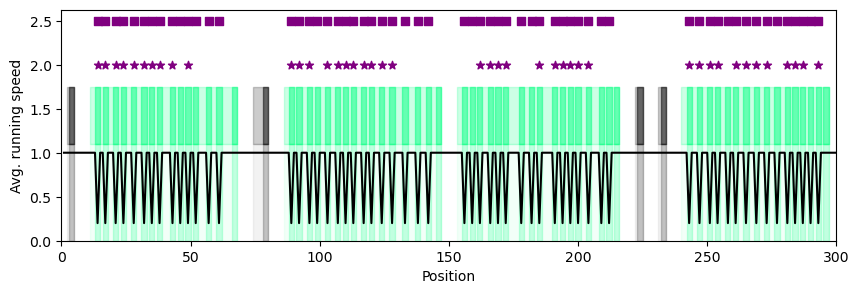

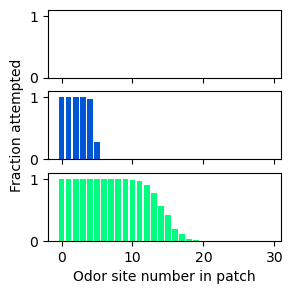

In [5]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_agent_02_test_2025-01-31_09_45_34_904554_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 1
[ 0.  0. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:82: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)


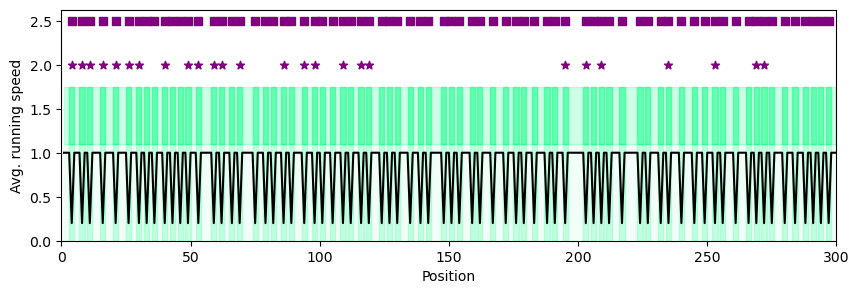

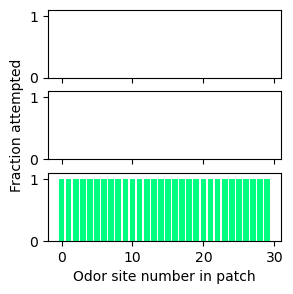

In [13]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_agent_02_test_half_visual_cue_2025-01-31_10_10_30_362042_var_noise_0_activity_weight_0/state',
    env_idx=0,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 1
[ 0. 10.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:82: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)


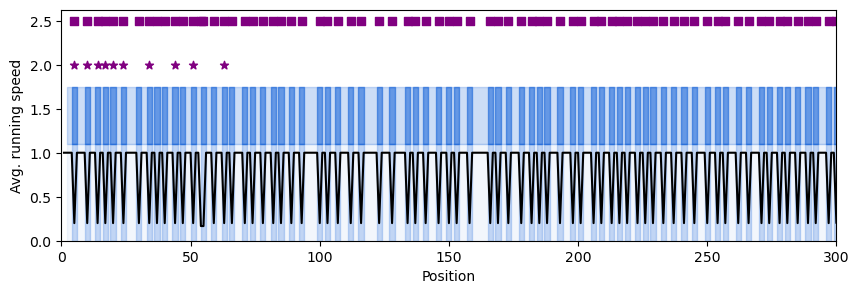

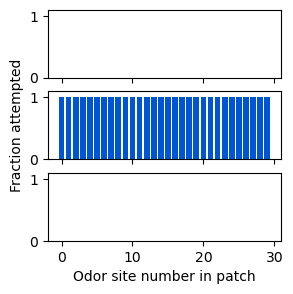

In [14]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_agent_02_test_half_visual_cue_2025-01-31_10_10_30_362042_var_noise_0_activity_weight_0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 2
[ 0.  0. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:82: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k], color=c)


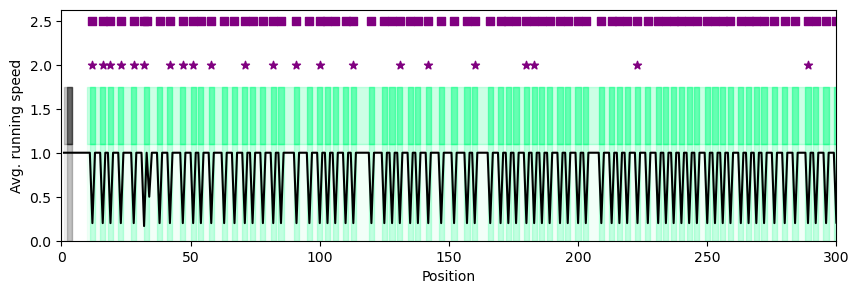

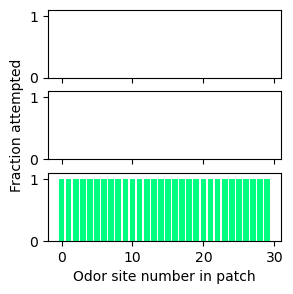

In [15]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_agent_02_test_075_visual_cue_2025-01-31_10_28_12_346647_var_noise_0_activity_weight_0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\311738483.py:14: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 2004
[ 0. 10. 30.]


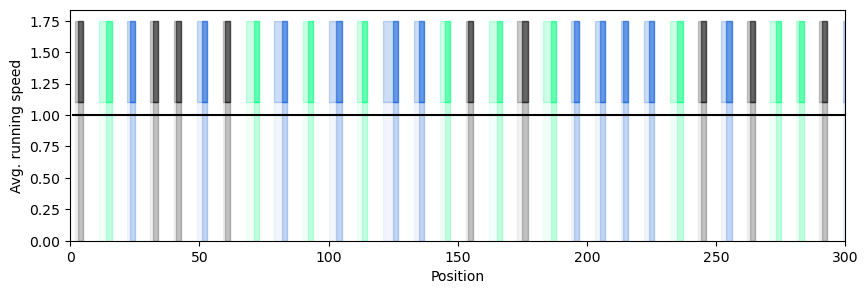

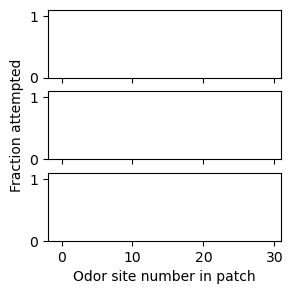

In [16]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_agent_02_test_half_odor_cue_2025-01-31_10_39_37_013684_var_noise_0_activity_weight_0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 262
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:101: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


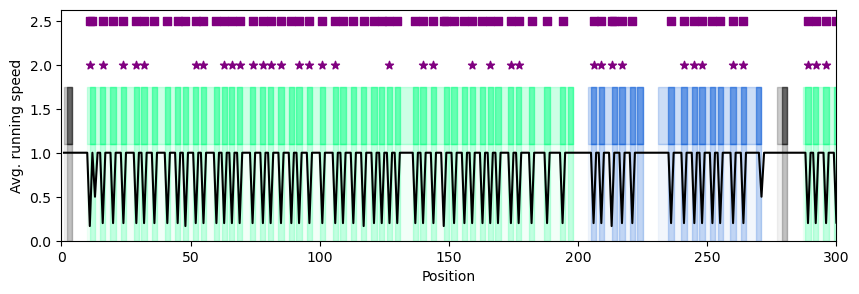

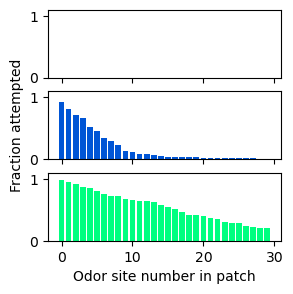

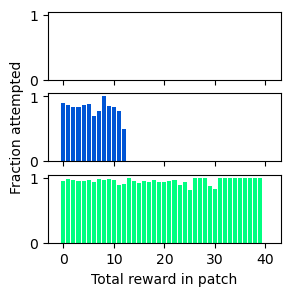

In [44]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
    update_num=0,
)

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl']


C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:15: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(b_data['all_dwell_times'])), 1/np.array(b_data['all_dwell_times']), c='black', zorder=0)


Patch count: 259
[ 0. 10. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_59248\4107729331.py:101: RuntimeWarning: invalid value encountered in divide
  axs[k].bar(x, acc_reward_stops_for_patch_type[k, :] / acc_reward_stop_opportunities_for_patch_type[k, :], color=c)


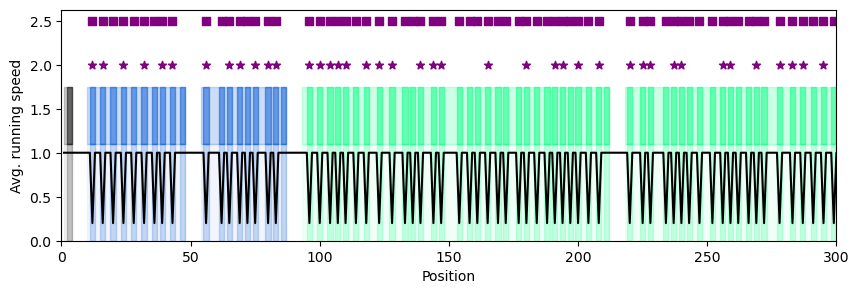

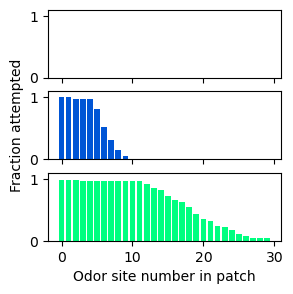

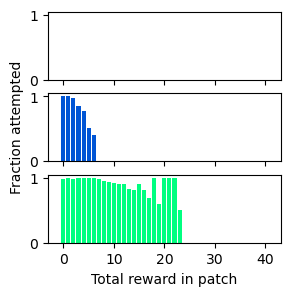

In [46]:
plot_sesson(
    '../../results/rl_agent_outputs/fixed_odor_acc_reward_2025-02-09_18_56_19_657542_var_noise_0.0001_activity_weight_1.0/state',
    env_idx=1,
    xlim=(0, 300),
    max_reward_param=30,
    max_reward_sites=30,
)

In [9]:
def plot_avg_stops_vs_reward_param(data_paths, update_num=None, max_reward_param=10, max_reward_sites=30, model_colors=None):

    cmap = mpl.colormaps['winter']
    if model_colors is None:
        model_colors = ['purple', 'green']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(6, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num)
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            rewards_at_positions = b_data['rewards_at_positions']
            reward_attempted_at_positions = b_data['reward_attempted_at_positions']
            all_patch_nums = b_data['current_patch_num']
            all_patch_reward_params = b_data['patch_reward_param']
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pstart = None
            last_reward_site_start = None
            patch_count = 0
            for i, pstart in enumerate(b_data['current_patch_start']):
                # print(f'Step {i}')
                if last_pstart is None or (pstart != last_pstart).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb = [pstart, pstart]
                    rw_site_counter = 0
                
                rwsb = copy(b_data['reward_bounds'][i])
                reward_site_start = int(rwsb[0])
                # print('rwsite_start', reward_site_start)
                # print('last_rwsite_start', last_reward_site_start)
                if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb[1] = rwsb[1]
                    else:
                        reward_param_of_stop.append(b_data['patch_reward_param'][i])
                        site_idx_of_stop.append(rw_site_counter)
                        if rw_site_counter < max_reward_sites:
                            site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                        rw_site_counter += 1
        
                last_pstart = pstart
                last_reward_site_start = reward_site_start
            
            print(reward_param_for_patch_type)
    
            scale = 1
            fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
                c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                axs[k].bar(x, cdf, color=c)
                axs[k].set_ylim(0, 1.1)
    
                pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
                # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
    
                avg_stops_for_patch_type[k] = np.dot(pdf, x)
    
            axs[1].set_ylabel('Fraction attempted')
            axs[2].set_xlabel('Odor site number in patch')
    
            ordering = np.argsort(reward_param_for_patch_type)
    
            axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(reward_param_for_patch_type[ordering], avg_stops_for_patch_type[ordering], c=model_colors[idx_data_path])
            axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c=model_colors[idx_data_path])
        
    axs_sensitivity[0, 0].set_ylim(0)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

['00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl', '02800.pkl', '02850.pkl', '02900.pkl', '02950.pkl', '03000.pkl', '03050.pkl', '03100.pkl', '03150.pkl', '03200.pkl', '03250.pkl', '03300.pkl', '03350.pkl', '03400.pkl', '03450.pkl', '03500.pkl', '03550.pkl', '03600.pkl', '03650.pkl', '03700.pkl', '03750.pkl', '03800.pkl', '03850.pkl'

C:\Users\david.bell\AppData\Local\Temp\ipykernel_11628\2610143325.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]
[ 0. 10. 30.]


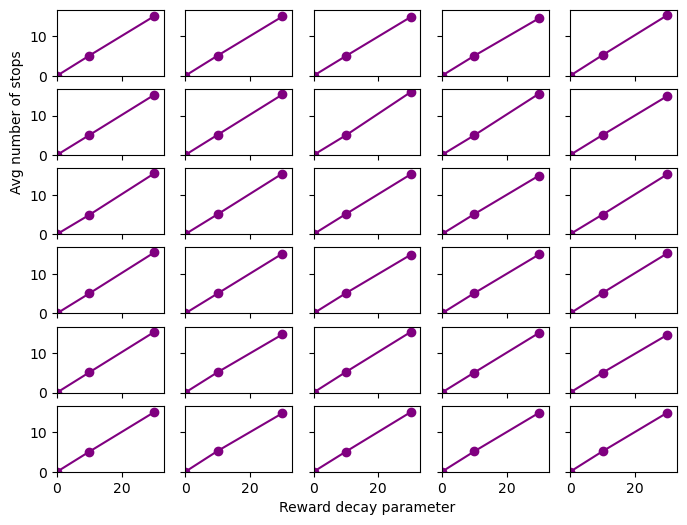

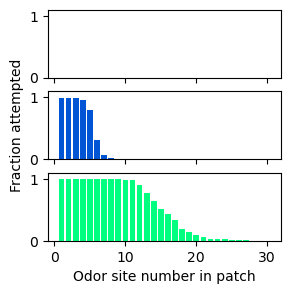

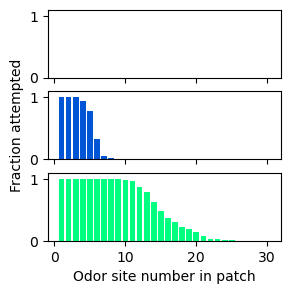

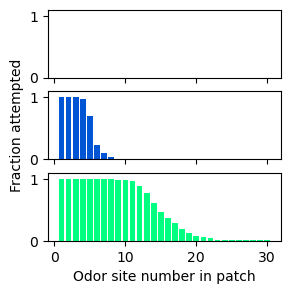

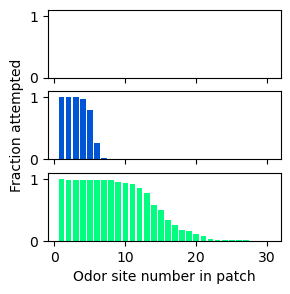

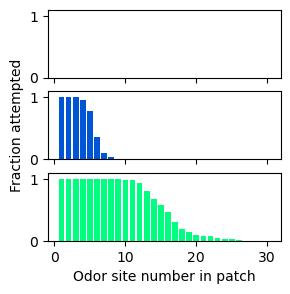

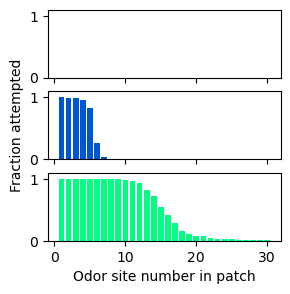

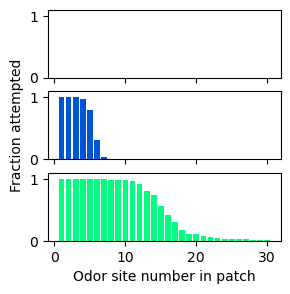

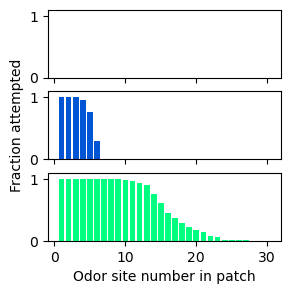

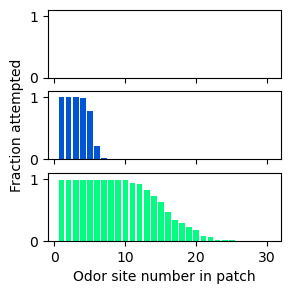

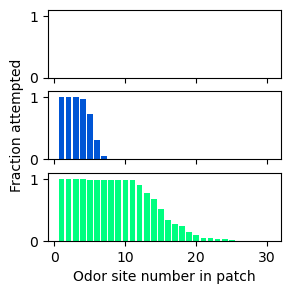

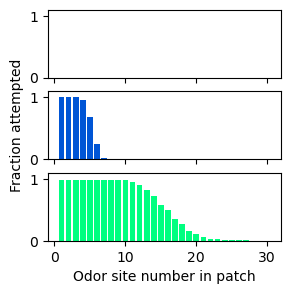

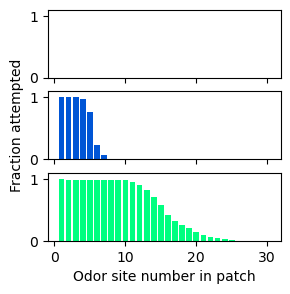

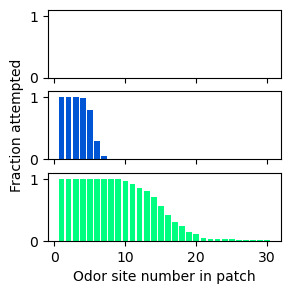

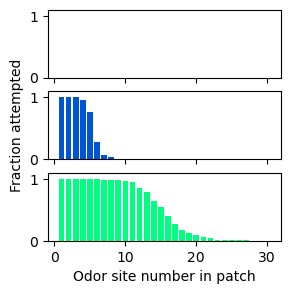

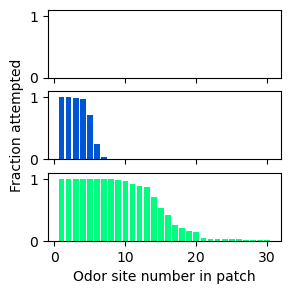

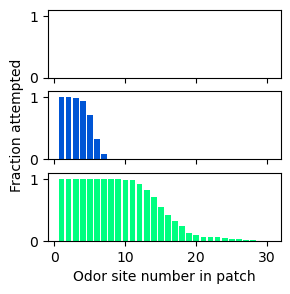

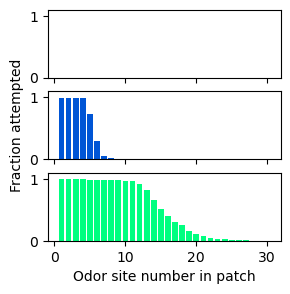

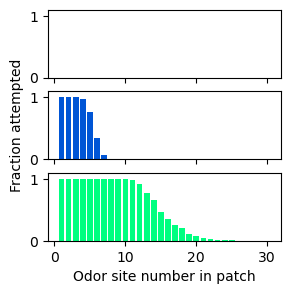

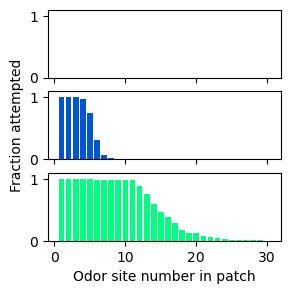

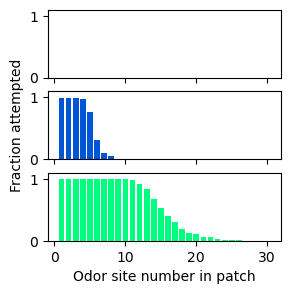

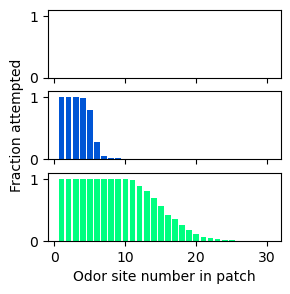

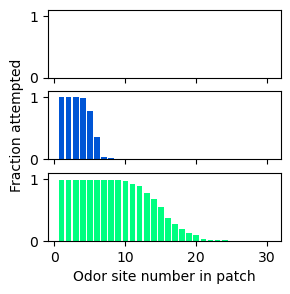

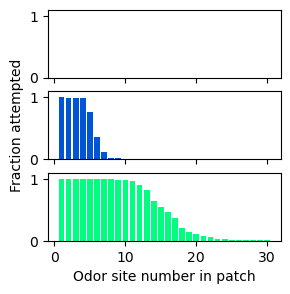

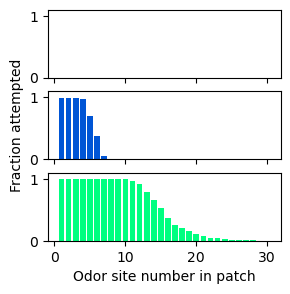

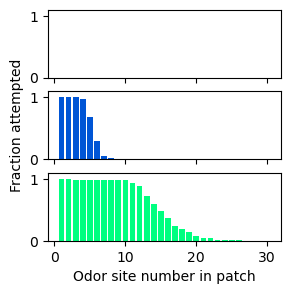

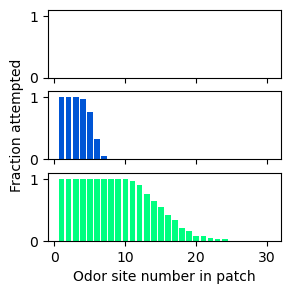

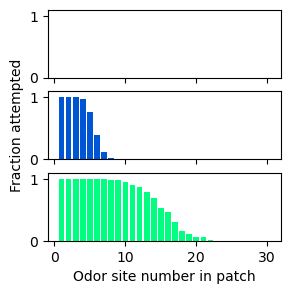

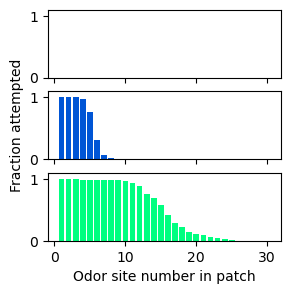

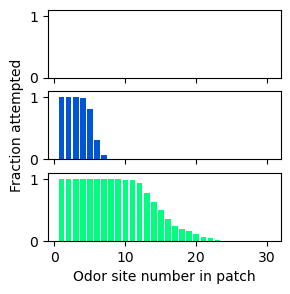

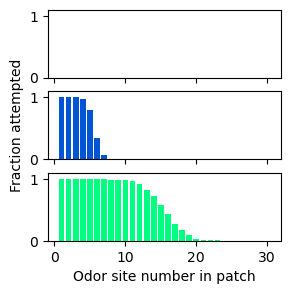

In [114]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/structural_priors_in_rl_fixed_curr_optim_02_2024-12-04_22_56_50_041229_var_noise_0.0001_activity_weight_1.0/state',
    ],
    max_reward_param=30,
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
[ 0.  0. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\2610143325.py:66: RuntimeWarning: invalid value encountered in divide
  cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]


[ 0. 10.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0.  0. 30.]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_49792\2610143325.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0.  0. 30.]
[ 0. 10.]
[ 0. 10.]


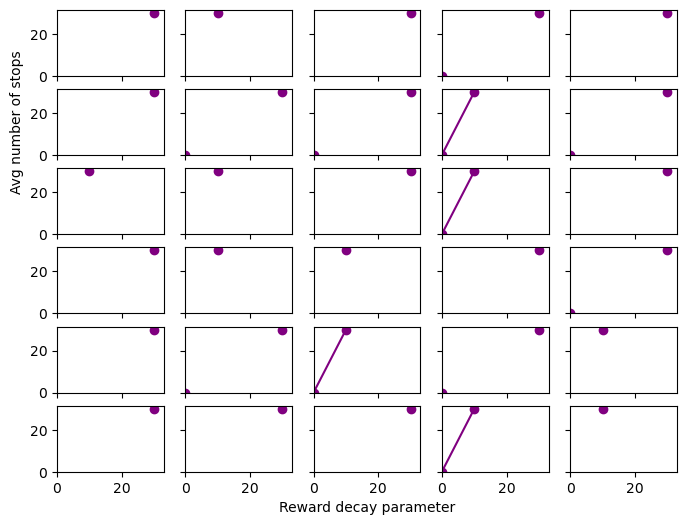

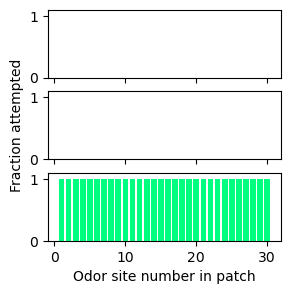

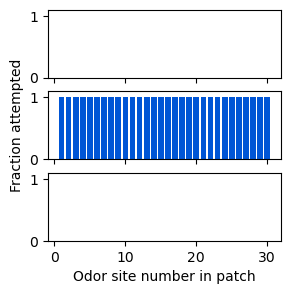

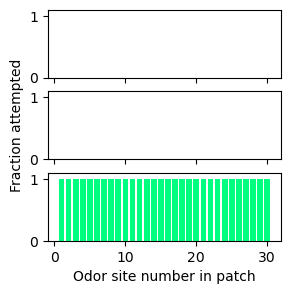

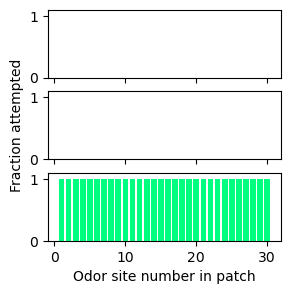

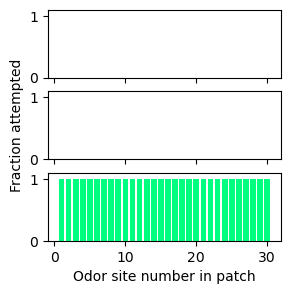

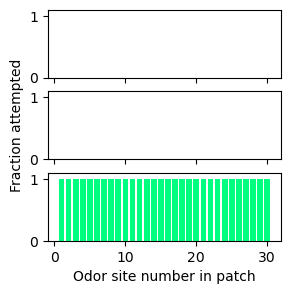

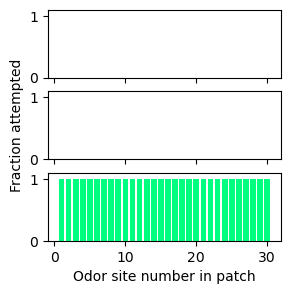

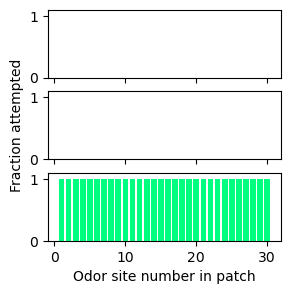

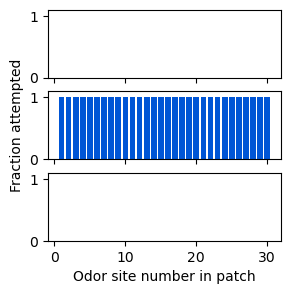

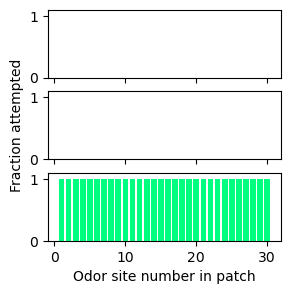

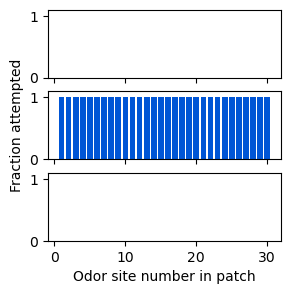

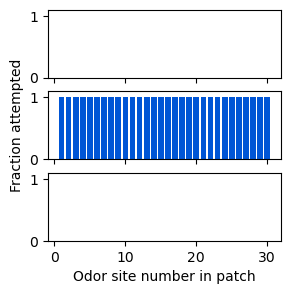

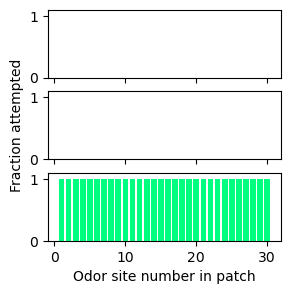

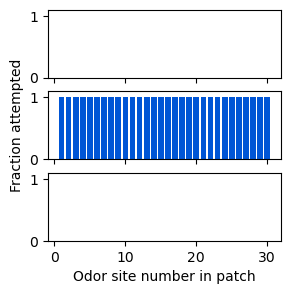

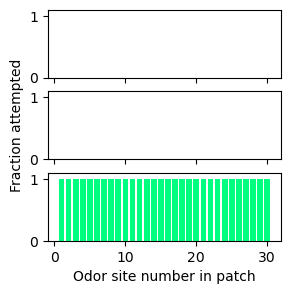

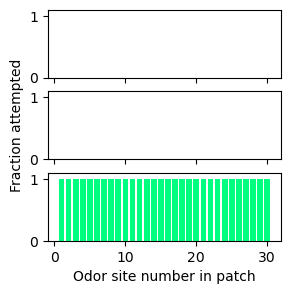

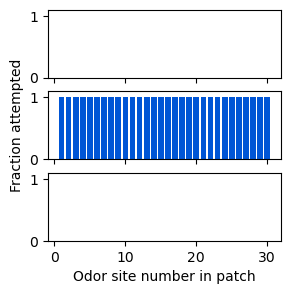

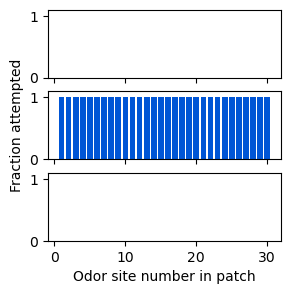

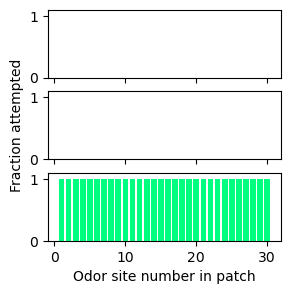

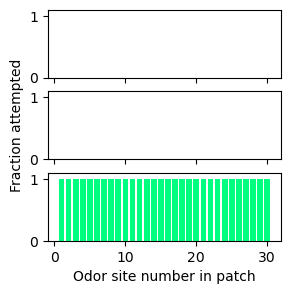

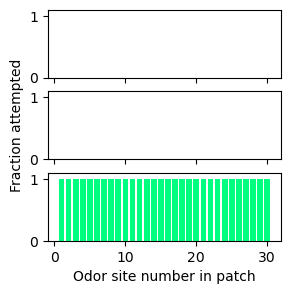

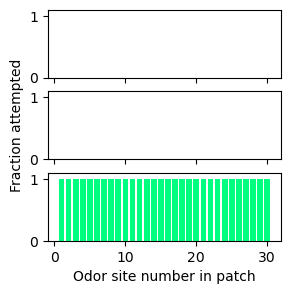

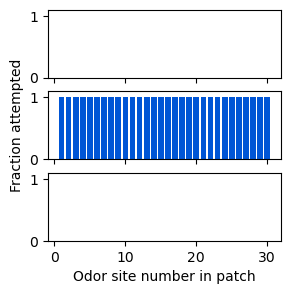

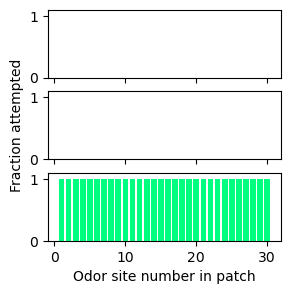

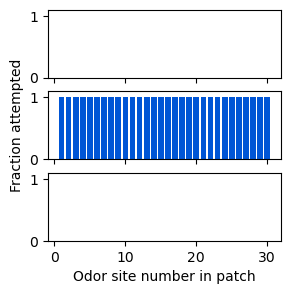

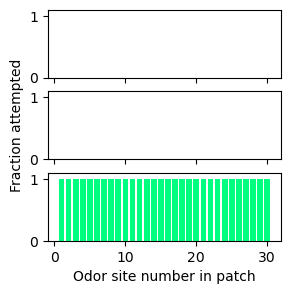

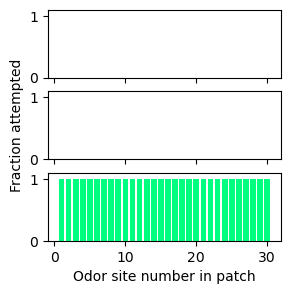

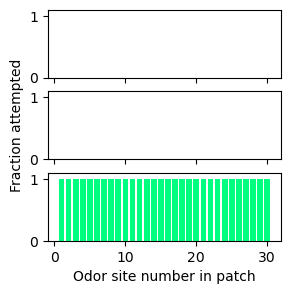

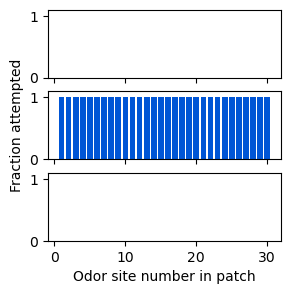

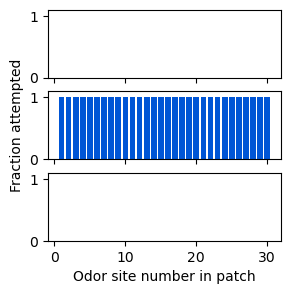

In [12]:
plot_avg_stops_vs_reward_param([
        '../../results/rl_agent_outputs/fixed_agent_02_test_half_visual_cue_2025-01-31_10_10_30_362042_var_noise_0_activity_weight_0/state',
    ],
    max_reward_param=30,
)